In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import folium
import matplotlib
import matplotlib.ticker as mticker
from scipy.stats import linregress
from matplotlib.font_manager import FontProperties

# Create a FontProperties object with bold font weight
bold_font = FontProperties(weight='bold')



## Plot all included sites

In [2]:
sntls = pd.read_csv('/home/cdalden/summa_setup/analysis/sntl_list_ski_temps.csv', index_col=0)
sntls['elev'] = sntls['elev']/3.281

In [3]:
# Normalize the 'elev' column for color mapping
norm = matplotlib.colors.Normalize(vmin=sntls['elev'].min(), vmax=sntls['elev'].max())
colormap = matplotlib.cm.get_cmap('viridis')

# Create a map centered around the mean coordinates
m = folium.Map(location=[sntls['lat'].mean(), sntls['lon'].mean()], zoom_start=4, control_scale=True)

# Add the satellite imagery
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('http://tile.stamen.com/terrain/{z}/{x}/{y}.jpg', attr='terrain').add_to(m)
folium.TileLayer('http://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/MapServer/tile/{z}/{y}/{x}', attr='World Imagery').add_to(m)
folium.LayerControl().add_to(m)

# Add the points colored by elevation
for idx, row in sntls.iterrows():
    color = matplotlib.colors.to_hex(colormap(norm(row['elev'])))
    tooltip_text = f"{row['site_name']}, elev: {row['elev']}"  # Create tooltip text
    folium.CircleMarker(
        location=(row['lat'], row['lon']), 
        radius=5, 
        color=color, 
        fill=True, 
        tooltip=tooltip_text  # Use tooltip text here
    ).add_to(m)

# Show the map
m

/tmp/ipykernel_29169/2355117360.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('viridis')


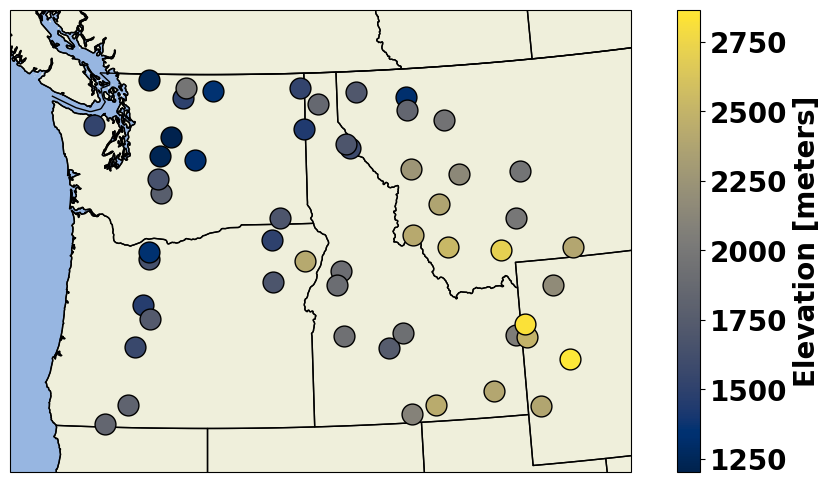

In [4]:
import cartopy.mpl.gridliner as gridliner

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points colored by elevation
for idx, row in sntls.iterrows():
    color = matplotlib.colors.to_hex(plt.cm.cividis(norm(row['elev'])))
    ax.plot(row['lon'], row['lat'], marker='o', color=color, markersize=15, mec='k', transform=ccrs.PlateCarree())

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.cividis, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Elevation [meters]', fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')

# # Add x and y ticks for lon and lat
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
# gl.top_labels = False
# gl.right_labels = False
# gl.xformatter = gridliner.LONGITUDE_FORMATTER
# gl.yformatter = gridliner.LATITUDE_FORMATTER

# plt.title('SNOTEL Sites Included in Analysis by Elevation')

# Show the map
plt.show()

## Crust summary stats for all sites

In [5]:
# Load the NetCDF files
ds = xr.open_dataset('/home/cdalden/summa_setup/analysis/crust_stats_ski_snotels_vFeb20.nc')


In [6]:
# Calculate 'percent_crust_days' for 'current' and '+2K'
ds['percent_crust_days'] = ds['crusts_binary']/ds['snow_on']*100
# ds_avg_current = ds['percent_crust_days'].sel(model_run='current').mean(dim='time')
# ds_avg_2K = ds['percent_crust_days'].sel(model_run=comparison_run).mean(dim='time')

olallie = ds.sel(site='hartspass')
olallie = olallie.sel(time=olallie['time.year'] > 2023)

olallie.sel(model_run='current').snow_on.values/24

array([256.20833333])

### Plot sites with colors for binary crusts

/tmp/ipykernel_29169/2810167150.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('PuOr')


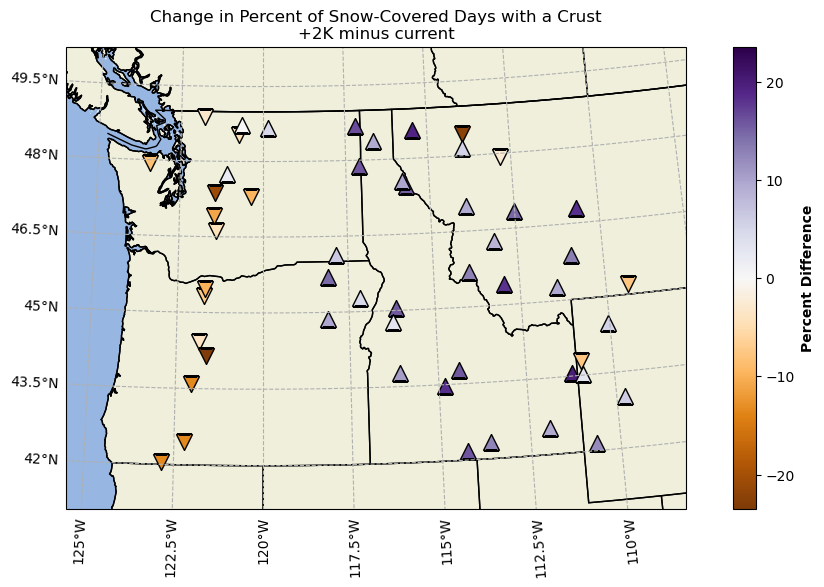

In [7]:
comparison_run = '+2K'

# Calculate 'percent_crust_days' for 'current' and '+2K'
ds['percent_crust_days'] = ds['crusts_binary']/ds['snow_on']*100
ds_avg_current = ds['crusts_binary'].sel(model_run='current').mean(dim='time')/24
ds_avg_2K = ds['crusts_binary'].sel(model_run=comparison_run).mean(dim='time')/24

# Calculate the difference
ds_diff = ds_avg_2K - ds_avg_current

# Ensure ds_diff is an xarray.DataArray
ds_diff = ds_diff.to_dataset(name='percent_crust_days_diff')

# Convert the Dataset to a DataFrame
df_diff = ds_diff.to_dataframe().reset_index()

# Merge the difference DataFrame with the original DataFrame on the site column
df_merged = pd.merge(sntls, df_diff, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join

# Normalize the 'percent_crust_days' column for color mapping
# Normalize the 'percent_crust_days_diff' column for color mapping
norm = matplotlib.colors.Normalize(vmin=df_merged['percent_crust_days_diff'].min(), 
                                   vmax=-df_merged['percent_crust_days_diff'].min())
colormap = matplotlib.cm.get_cmap('PuOr')

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points as arrows
for idx, row in df_merged.iterrows():
    if pd.notna(row['percent_crust_days_diff']):
        color = matplotlib.colors.to_hex(colormap(norm(row['percent_crust_days_diff'])))
        marker = '^' if row['percent_crust_days_diff'] > 0 else 'v'
        # size = np.abs(row['percent_crust_days_diff']) * 0.8  # Adjust the scaling factor as needed
        size = 12
        ax.plot(row['lon'], row['lat'], marker=marker, color=color, markersize=size, markeredgecolor='k', transform=ccrs.PlateCarree())

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Create the colorbar and set the label with bold font weight
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Percent Difference', fontweight='bold')

# Add a legend for the arrow sizes
for magnitude in [5, 10, 15, 20]:  # Example magnitudes
    ax.plot([], [], marker='^', color='k', markersize=magnitude * 0.8, label=f'{magnitude}%')

# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER

ax.set_title(f'Change in Percent of Snow-Covered Days with a Crust\n{comparison_run} minus current')

# Show the map
plt.show()

In [8]:
# Assuming ds is your xarray Dataset and comparison_run is defined
comparison_run = '+4K'  # Example comparison run

# Calculate 'percent_crust_days' for 'current' and '+2K'
ds['percent_crust_days'] = ds['crusts_binary'] / 121 * 100 / 24
ds_percent_crusts = ds['percent_crust_days']
# ds_percent_crusts = ds['crusts_binary'].sel(model_run='current').mean(dim='time')/24

# Calculate the average percent crust days for the 'current' and 'comparison_run' model runs
ds_avg_current = ds['percent_crust_days'].sel(model_run='current').mean(dim='time')
ds_avg_comparison = ds['percent_crust_days'].sel(model_run=comparison_run).mean(dim='time')


# Calculate the difference
ds_diff = ds_avg_comparison - ds_avg_current

# Ensure ds_diff is an xarray.DataArray
ds_diff = ds_diff.to_dataset(name='percent_crust_days_diff')
ds_percent_crusts = ds_percent_crusts.to_dataset(name='percent_crust_days')


# Convert the Dataset to a DataFrame
df_diff = ds_diff.to_dataframe().reset_index()
df_percent_crusts = ds_percent_crusts.to_dataframe().reset_index()

# Merge the difference DataFrame with the original DataFrame on the site column
df_merged = pd.merge(sntls, df_diff, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join
df_merged = pd.merge(df_merged, df_percent_crusts, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join

# Replace inf and -inf with NaN
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
df_merged.dropna(subset=['percent_crust_days', 'percent_crust_days_diff'], inplace=True)


/tmp/ipykernel_29169/3547999170.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap_current = matplotlib.cm.get_cmap('cividis_r')
/tmp/ipykernel_29169/3547999170.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap_diff = matplotlib.cm.get_cmap('coolwarm_r')


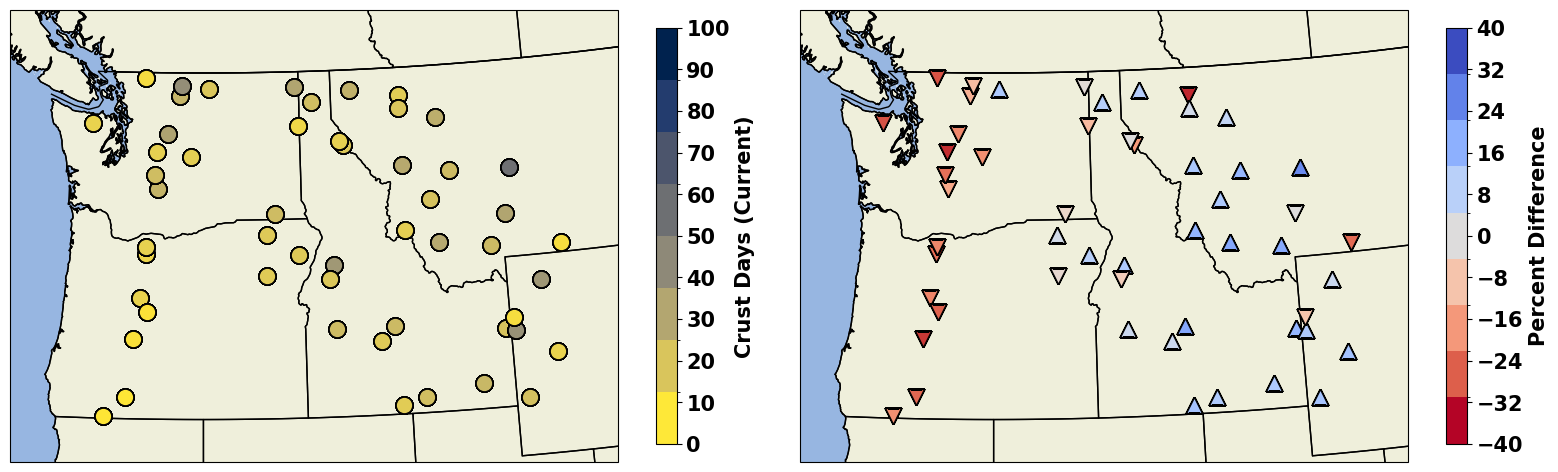

In [9]:
from matplotlib.ticker import MaxNLocator
# Calculate vmin and vmax for each plot
vmin_current = 0
vmax_current = 100
vmin_diff = -40
# vmax_diff = df_merged['percent_crust_days_diff'].max()
vmax_diff = 40

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5)})

fig.subplots_adjust(wspace=0.04)

# Plot for model_run='current' on the left subplot
ax1.set_extent([sntls['lon'].min() - 2, sntls['lon'].max() + 1, sntls['lat'].min() - 1, sntls['lat'].max() + 1], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.STATES)  # Add state boundaries

# Normalize the 'percent_crust_days' column for color mapping
norm_current = matplotlib.colors.Normalize(vmin=vmin_current, vmax=vmax_current)
colormap_current = matplotlib.cm.get_cmap('cividis_r')

# Plot the percent crust days for 'current'
for idx, row in df_merged.iterrows():
    if pd.notna(row['percent_crust_days']):
        color = matplotlib.colors.to_hex(colormap_current(norm_current(row['percent_crust_days'])))
        marker = 'o'
        size = 12
        ax1.plot(row['lon'], row['lat'], marker=marker, color=color, markersize=size, markeredgecolor='k', transform=ccrs.PlateCarree())

# ax1.set_title('Percent Crust Days for Current Model Run', fontweight='bold')

# Plot for the difference on the right subplot
ax2.set_extent([sntls['lon'].min() - 2, sntls['lon'].max() + 1, sntls['lat'].min() - 1, sntls['lat'].max() + 1], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.STATES)  # Add state boundaries

# Normalize the 'percent_crust_days_diff' column for color mapping
norm_diff = matplotlib.colors.Normalize(vmin=vmin_diff, vmax=vmax_diff)
colormap_diff = matplotlib.cm.get_cmap('coolwarm_r')

# Add the points as arrows
for idx, row in df_merged.iterrows():
    if pd.notna(row['percent_crust_days_diff']):
        color = matplotlib.colors.to_hex(colormap_diff(norm_diff(row['percent_crust_days_diff'])))
        marker = '^' if row['percent_crust_days_diff'] > 0 else 'v'
        size = 12
        ax2.plot(row['lon'], row['lat'], marker=marker, color=color, markersize=size, markeredgecolor='k', transform=ccrs.PlateCarree())

# ax2.set_title(f'Change in Percent of Snow-Covered Days with a Crust\n+2$\degree$C minus current', fontweight='bold')

# Create discrete colorbars
bounds_current = np.linspace(vmin_current, vmax_current, 9)
norm_current = matplotlib.colors.BoundaryNorm(bounds_current, colormap_current.N)
sm_current = plt.cm.ScalarMappable(cmap=colormap_current, norm=norm_current)
sm_current.set_array([])

bounds_diff = np.linspace(vmin_diff, vmax_diff, 10)
norm_diff = matplotlib.colors.BoundaryNorm(bounds_diff, colormap_diff.N)
sm_diff = plt.cm.ScalarMappable(cmap=colormap_diff, norm=norm_diff)
sm_diff.set_array([])

# Create the colorbars and set the labels with bold font weight
cbar_current = fig.colorbar(sm_current, ax=ax1, orientation='vertical', pad=0.05, shrink=0.45)
cbar_current.set_label('Crust Days (Current)', fontweight='bold', fontsize=15)
cbar_current.ax.tick_params(labelsize=15)
# Set the colorbar to only show whole number ticks
cbar_current.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# Set the font weight of the tick labels to bold
for label in cbar_current.ax.get_yticklabels():
    label.set_fontweight('bold')

cbar_diff = fig.colorbar(sm_diff, ax=ax2, orientation='vertical', pad=0.05, shrink=0.45)
cbar_diff.set_label('Percent Difference', fontweight='bold', fontsize=15)
cbar_diff.ax.tick_params(labelsize=15)
cbar_diff.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
for label in cbar_diff.ax.get_yticklabels():
    label.set_fontweight('bold')

# Add a legend for the arrow sizes
for magnitude in [5, 10, 15, 20]:  # Example magnitudes
    ax2.plot([], [], marker='^', color='k', markersize=magnitude * 0.8, label=f'{magnitude}%')

# Add x and y ticks for lon and lat
# gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
# gl1.top_labels = False
# gl1.right_labels = False
# gl1.xformatter = LONGITUDE_FORMATTER
# gl1.yformatter = LATITUDE_FORMATTER
# Make x and y tick labels bold and rotate x tick labels by 30 degrees
# gl1.xlabel_style = {'weight': 'bold', 'size': 20, 'rotation': 30}
# gl1.ylabel_style = {'weight': 'bold', 'size': 20}

# gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
# gl2.top_labels = False
# gl2.right_labels = False
# gl2.xformatter = LONGITUDE_FORMATTER
# gl2.yformatter = LATITUDE_FORMATTER
# # Make x and y tick labels bold and rotate x tick labels by 30 degrees
# gl2.xlabel_style = {'weight': 'bold', 'size': 20, 'rotation': 30}
# gl2.ylabel_style = {'weight': 'bold', 'size': 20}

# Add label 'A' to the top right of the first subplot with a white background
# ax1.text(0.12, 0.97, ' A ', transform=ax1.transAxes, fontsize=25, fontweight='bold', va='top', ha='right',
#            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# # Add label 'B' to the top right of the second subplot with a white background
# ax2.text(0.12, 0.97, ' B ', transform=ax2.transAxes, fontsize=25, fontweight='bold', va='top', ha='right',
#            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Show the map
# plt.show()

# plt.savefig('/home/cdalden/summa_setup/analysis/figures/crust_change_summary.png', dpi=300, bbox_inches='tight')

## Plotting change in crust days (not percent)

In [29]:
# Assuming ds is your xarray Dataset and comparison_run is defined
comparison_run = '+4K'  # Example comparison run

# Calculate the average percent crust days for the 'current' and 'comparison_run' model runs
ds_avg_current = ds['crusts_binary'].sel(model_run='current').mean(dim='time')
ds_avg_comparison = ds['crusts_binary'].sel(model_run=comparison_run).mean(dim='time')

ds_crusts = ds['crusts_binary']/24

# Calculate the difference
ds_diff = (ds_avg_comparison - ds_avg_current)/24

# Ensure ds_diff is an xarray.DataArray
ds_diff = ds_diff.to_dataset(name='crust_days_diff')
ds_crusts = ds_crusts.to_dataset(name='crust_days')


# Convert the Dataset to a DataFrame
df_diff = ds_diff.to_dataframe().reset_index()
df_crusts = ds_crusts.to_dataframe().reset_index()

# Merge the difference DataFrame with the original DataFrame on the site column
df_merged = pd.merge(sntls, df_diff, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join
df_merged = pd.merge(df_merged, df_crusts, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join

# Replace inf and -inf with NaN
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
df_merged.dropna(subset=['crust_days', 'crust_days_diff'], inplace=True)

/tmp/ipykernel_29169/3937660613.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap_current = matplotlib.cm.get_cmap('cividis_r')
/tmp/ipykernel_29169/3937660613.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap_diff = matplotlib.cm.get_cmap('coolwarm_r')


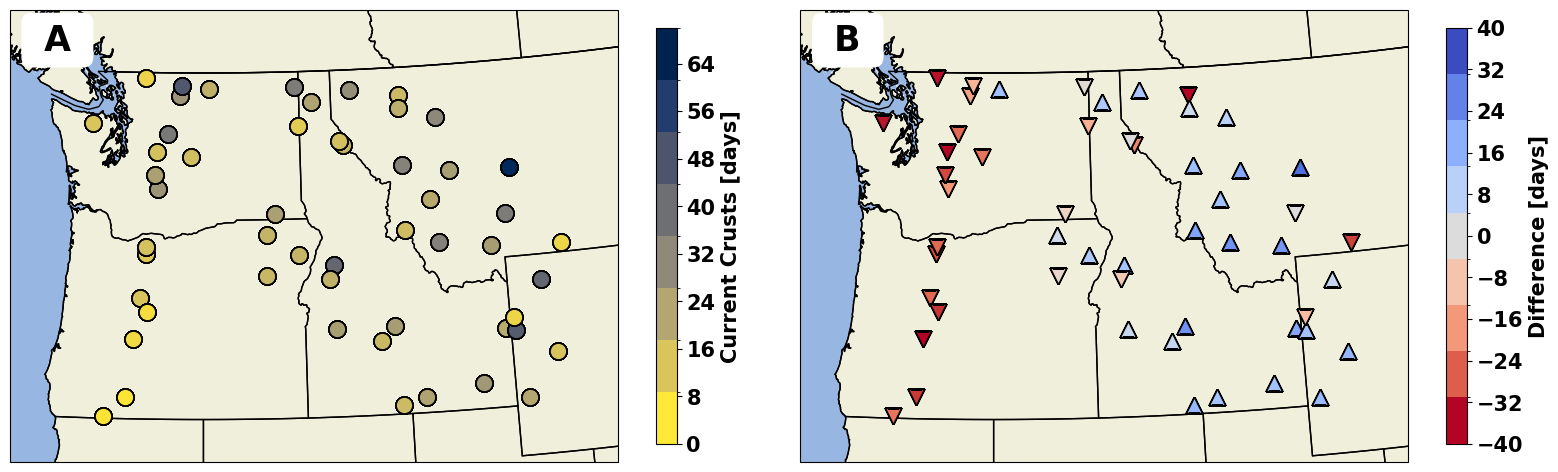

In [31]:
from matplotlib.ticker import MaxNLocator
# Calculate vmin and vmax for each plot
vmin_current = 0
vmax_current = 70
vmin_diff = -40
# vmax_diff = df_merged['percent_crust_days_diff'].max()
vmax_diff = 40

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5)})

fig.subplots_adjust(wspace=0.04)

# Plot for model_run='current' on the left subplot
ax1.set_extent([sntls['lon'].min() - 2, sntls['lon'].max() + 1, sntls['lat'].min() - 1, sntls['lat'].max() + 1], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.STATES)  # Add state boundaries

# Normalize the 'percent_crust_days' column for color mapping
norm_current = matplotlib.colors.Normalize(vmin=vmin_current, vmax=vmax_current)
colormap_current = matplotlib.cm.get_cmap('cividis_r')

# Plot the percent crust days for 'current'
for idx, row in df_merged.iterrows():
    if pd.notna(row['crust_days']):
        color = matplotlib.colors.to_hex(colormap_current(norm_current(row['crust_days'])))
        marker = 'o'
        size = 12
        ax1.plot(row['lon'], row['lat'], marker=marker, color=color, markersize=size, markeredgecolor='k', transform=ccrs.PlateCarree())

# ax1.set_title('Percent Crust Days for Current Model Run', fontweight='bold')

# Plot for the difference on the right subplot
ax2.set_extent([sntls['lon'].min() - 2, sntls['lon'].max() + 1, sntls['lat'].min() - 1, sntls['lat'].max() + 1], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.STATES)  # Add state boundaries

# Normalize the 'percent_crust_days_diff' column for color mapping
norm_diff = matplotlib.colors.Normalize(vmin=vmin_diff, vmax=vmax_diff)
colormap_diff = matplotlib.cm.get_cmap('coolwarm_r')

# Add the points as arrows
for idx, row in df_merged.iterrows():
    if pd.notna(row['crust_days_diff']):
        color = matplotlib.colors.to_hex(colormap_diff(norm_diff(row['crust_days_diff'])))
        marker = '^' if row['crust_days_diff'] > 0 else 'v'
        size = 12
        ax2.plot(row['lon'], row['lat'], marker=marker, color=color, markersize=size, markeredgecolor='k', transform=ccrs.PlateCarree())

# ax2.set_title(f'Change in Percent of Snow-Covered Days with a Crust\n+2$\degree$C minus current', fontweight='bold')

# Create discrete colorbars
bounds_current = np.linspace(vmin_current, vmax_current, 9)
norm_current = matplotlib.colors.BoundaryNorm(bounds_current, colormap_current.N)
sm_current = plt.cm.ScalarMappable(cmap=colormap_current, norm=norm_current)
sm_current.set_array([])

bounds_diff = np.linspace(vmin_diff, vmax_diff, 10)
norm_diff = matplotlib.colors.BoundaryNorm(bounds_diff, colormap_diff.N)
sm_diff = plt.cm.ScalarMappable(cmap=colormap_diff, norm=norm_diff)
sm_diff.set_array([])

# Create the colorbars and set the labels with bold font weight
cbar_current = fig.colorbar(sm_current, ax=ax1, orientation='vertical', pad=0.05, shrink=0.45)
cbar_current.set_label('Current Crusts [days]', fontweight='bold', fontsize=15)
cbar_current.ax.tick_params(labelsize=15)
# Set the colorbar to only show whole number ticks
cbar_current.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# Set the font weight of the tick labels to bold
for label in cbar_current.ax.get_yticklabels():
    label.set_fontweight('bold')

cbar_diff = fig.colorbar(sm_diff, ax=ax2, orientation='vertical', pad=0.05, shrink=0.45)
cbar_diff.set_label('Difference [days]', fontweight='bold', fontsize=15)
cbar_diff.ax.tick_params(labelsize=15)
cbar_diff.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
for label in cbar_diff.ax.get_yticklabels():
    label.set_fontweight('bold')

# Add a legend for the arrow sizes
for magnitude in [5, 10, 15, 20]:  # Example magnitudes
    ax2.plot([], [], marker='^', color='k', markersize=magnitude * 0.8, label=f'{magnitude}%')

# Add label 'A' to the top right of the first subplot with a white background
ax1.text(0.12, 0.97, ' A ', transform=ax1.transAxes, fontsize=25, fontweight='bold', va='top', ha='right',
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Add label 'B' to the top right of the second subplot with a white background
ax2.text(0.12, 0.97, ' B ', transform=ax2.transAxes, fontsize=25, fontweight='bold', va='top', ha='right',
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

plt.savefig('/home/cdalden/summa_setup/analysis/figures/crust_change_summary.png', dpi=300, bbox_inches='tight')

### Plotting change in snow-on days

<>:61: SyntaxWarning: invalid escape sequence '\d'
<>:61: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_29169/2398270642.py:61: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'Percent Change in Snow-Covered Days\n2$\degree$C minus current', fontweight='bold')
/tmp/ipykernel_29169/2398270642.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('afmhot')


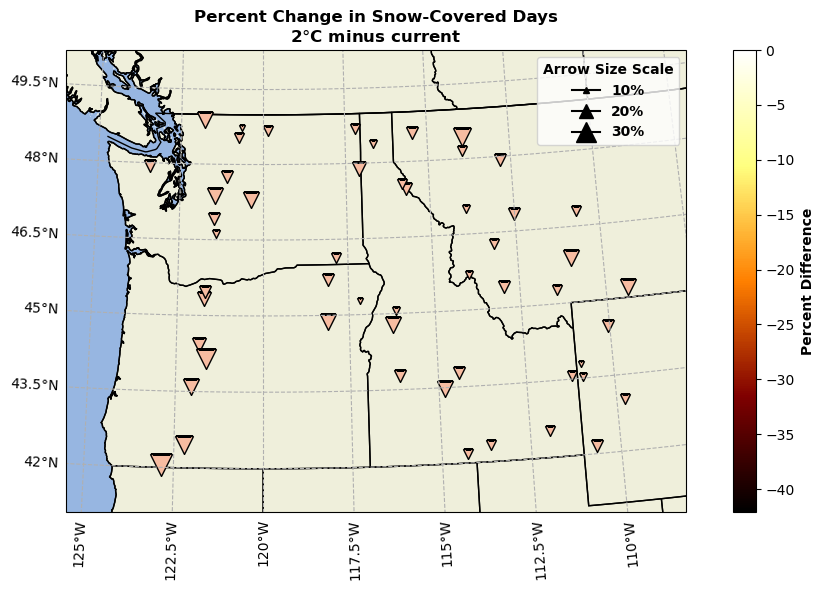

In [12]:
comparison_run = '+2K'

ds_avg_current = ds['snow_on'].sel(model_run='current').mean(dim='time')/24
ds_avg_2K = ds['snow_on'].sel(model_run=comparison_run).mean(dim='time')/24

# Calculate the difference
ds_diff = ((ds_avg_2K - ds_avg_current)/ds_avg_current)*100
# ds_diff = ds_avg_current

# Convert the Dataset to a DataFrame
df_diff = ds_diff.to_dataframe().reset_index()

# Merge the difference DataFrame with the original DataFrame on the site column
df_merged = pd.merge(sntls, df_diff, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join

# Normalize the 'percent_crust_days' column for color mapping
norm = matplotlib.colors.Normalize(vmin=ds_diff.min()-10, vmax=0)
colormap = matplotlib.cm.get_cmap('afmhot')

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points as arrows
for idx, row in df_merged.iterrows():
    if pd.notna(row['snow_on']):
        # color = matplotlib.colors.to_hex(colormap(norm(row['snow_on'])))
        marker = '^' if row['snow_on'] > 0 else 'v'
        size = np.abs(row['snow_on']) * 0.5 # Adjust the scaling factor as needed
        ax.plot(row['lon'], row['lat'], marker=marker, color=color, markersize=size, markeredgecolor='k', transform=ccrs.PlateCarree())

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Create the colorbar and set the label with bold font weight
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Percent Difference', fontweight='bold')

# Add a legend for the arrow sizes
for magnitude in [10, 20, 30]:  # Example magnitudes
    ax.plot([], [], marker='^', color='k', markersize=magnitude * 0.5, label=f'{magnitude}%')

# Set the legend with a bold title
ax.legend(title='Arrow Size Scale', loc='upper right', title_fontproperties=bold_font, prop=bold_font)

# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER

ax.set_title(f'Percent Change in Snow-Covered Days\n2$\degree$C minus current', fontweight='bold')

# Show the map
plt.show()

## Plot current snow-on days

/tmp/ipykernel_29169/3850268458.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('cool')


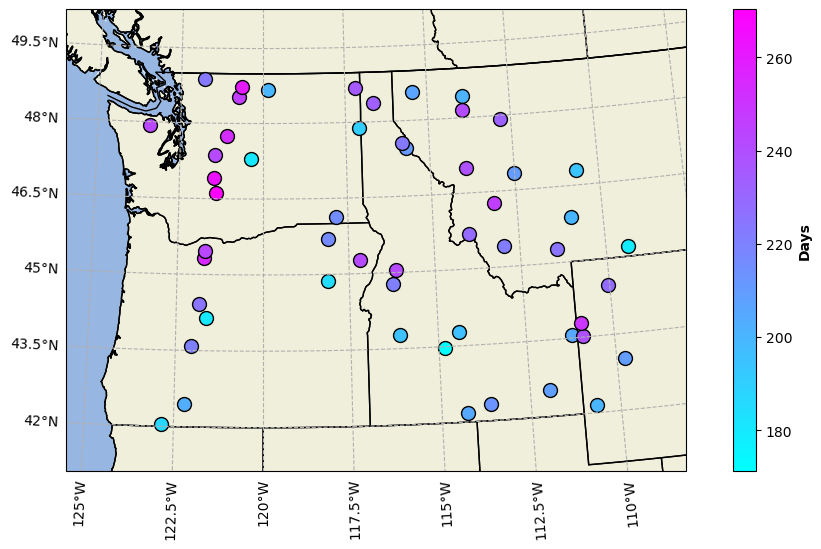

In [13]:
comparison_run = '+2K'

ds_avg_current = ds['snow_on'].sel(model_run='current').mean(dim='time')/24
ds_avg_2K = ds['snow_on'].sel(model_run=comparison_run).mean(dim='time')/24

# Calculate the difference
# ds_diff = ((ds_avg_2K - ds_avg_current)/ds_avg_current)*100
ds_diff = ds_avg_current

# Convert the Dataset to a DataFrame
df_diff = ds_diff.to_dataframe().reset_index()

# Merge the difference DataFrame with the original DataFrame on the site column
df_merged = pd.merge(sntls, df_diff, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join

# Normalize the 'percent_crust_days' column for color mapping
norm = matplotlib.colors.Normalize(vmin=ds_diff.min(), vmax=ds_diff.max())
colormap = matplotlib.cm.get_cmap('cool')

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points as arrows
for idx, row in df_merged.iterrows():
    if pd.notna(row['snow_on']):
        color = matplotlib.colors.to_hex(colormap(norm(row['snow_on'])))
        # marker = '^' if row['snow_on'] > 0 else 'v'
        size = np.abs(row['snow_on']) * 0.5 # Adjust the scaling factor as needed
        ax.plot(row['lon'], row['lat'], marker='o', color=color, markersize=10, markeredgecolor='k', transform=ccrs.PlateCarree())

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Create the colorbar and set the label with bold font weight
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Days', fontweight='bold')


# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER

# ax.set_title(f'Number of Days with Snow', fontweight='bold')

# Show the map
plt.show()

### Change in isothermal days

<>:63: SyntaxWarning: invalid escape sequence '\d'
<>:63: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_29169/3850642446.py:63: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'Percent Change in Isothermal Days\n2$\degree$C minus current', fontweight='bold')
/tmp/ipykernel_29169/3850642446.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('PuOr')


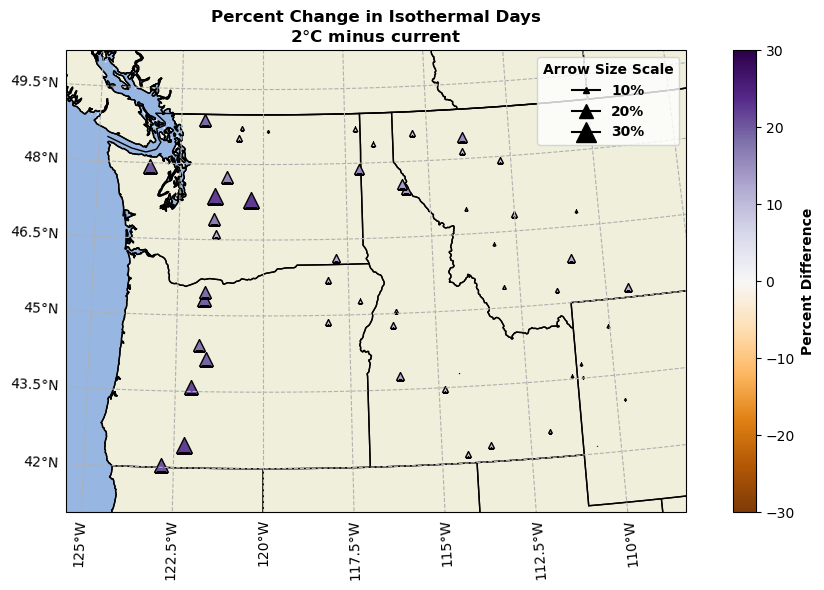

In [14]:
comparison_run = '+2K'

ds['percent_isothermal_days'] = ds['isothermal_days']/ds['snow_on']*100
ds_avg_current = ds['percent_isothermal_days'].sel(model_run='current').mean(dim='time')
ds_avg_2K = ds['percent_isothermal_days'].sel(model_run=comparison_run).mean(dim='time')

# Calculate the difference
ds_diff = ds_avg_2K - ds_avg_current

# Convert the Dataset to a DataFrame
df_diff = ds_diff.to_dataframe().reset_index()

# Merge the difference DataFrame with the original DataFrame on the site column
df_merged = pd.merge(sntls, df_diff, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join

# Normalize the 'percent_crust_days' column for color mapping
norm = matplotlib.colors.Normalize(vmin=-30, vmax=30)
colormap = matplotlib.cm.get_cmap('PuOr')

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, 
               sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points as arrows
for idx, row in df_merged.iterrows():
    if pd.notna(row['percent_isothermal_days']):
        color = matplotlib.colors.to_hex(colormap(norm(row['percent_isothermal_days'])))
        marker = '^' if row['percent_isothermal_days'] > 0 else 'v'
        size = np.abs(row['percent_isothermal_days']) * 0.5 # Adjust the scaling factor as needed
        ax.plot(row['lon'], row['lat'], marker=marker, color=color, markersize=size, 
                markeredgecolor='k', transform=ccrs.PlateCarree())


# Add a legend for the arrow sizes
for magnitude in [10, 20, 30]:  # Example magnitudes
    ax.plot([], [], marker='^', color='k', markersize=magnitude * 0.5, label=f'{magnitude}%')

ax.legend(title='Arrow Size Scale', loc='upper right', title_fontproperties=bold_font, prop=bold_font)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Create the colorbar and set the label with bold font weight
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Percent Difference', fontweight='bold')

# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER

ax.set_title(f'Percent Change in Isothermal Days\n2$\degree$C minus current', fontweight='bold')

# Show the map
plt.show()

### Scatterplot for mean crusts

['current' '+2K' '+4K']


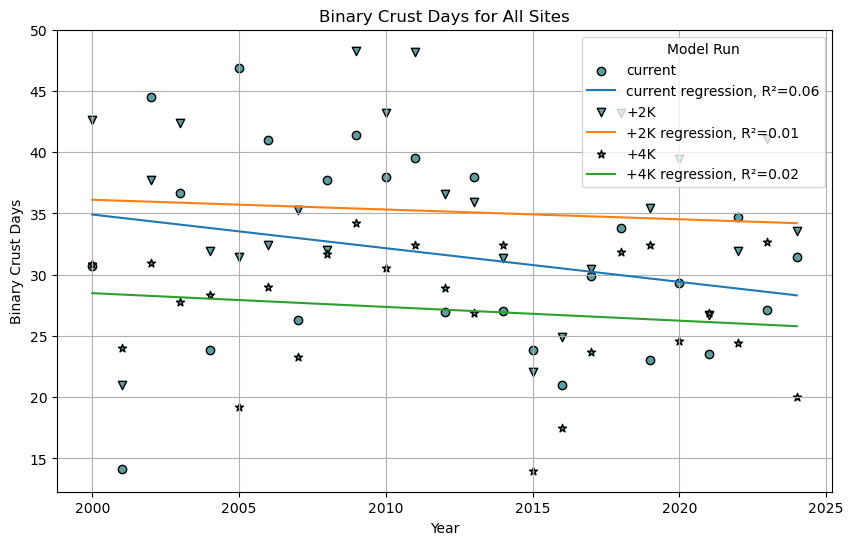

In [15]:
# Define a list of markers
markers = ['o', 'v', '*', '+', 'x', 'D', 'd', '|', '_']

# Average over all sites
ds_avg = ds.mean(dim='site')

# Select only the 'model_run' values 'current', '+2K', and '+4K'
ds_avg = ds_avg.where(ds_avg.model_run.isin(['current', '+2K', '+4K']), drop=True)

# Get the unique 'model_run' values
model_runs = ds_avg.model_run.values
print(model_runs)

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'mean_crusts' variable for the current 'model_run'
    crust_days = ds_avg['crusts_binary'].sel(model_run=model_run)/24 # will fix later, just to mask snow off for time being

    # Convert the time dimension to years for the x-axis
    years = crust_days.time.dt.year

    # Convert years and crust_days to numpy arrays
    years_np = years.values
    crust_days_np = crust_days.values

    # Remove NaN values
    # mask = ~np.isnan(years_np) & ~np.isnan(crust_days_np)
    mask = ~np.isnan(crust_days_np)
    years_np = years_np[mask]
    crust_days_np = crust_days_np[mask]

    # Check if the arrays are not empty
    if years_np.size > 0 and crust_days_np.size > 0:
        # Plot the data with a different marker for each 'model_run'
        plt.scatter(years_np, crust_days_np, marker=markers[i % len(markers)], label=model_run, color='cadetblue', ec='k')

            # Calculate the coefficients of the linear regression line
        slope, intercept, r_value, p_value, std_err = linregress(years_np, crust_days_np)

                # Calculate R-squared
        r_squared = r_value**2

        # Generate the x values for the regression line
        x = np.linspace(years_np.min(), years_np.max(), 100)

        # Generate the y values for the regression line
        y = slope * x + intercept

        # Plot the regression line
        plt.plot(x, y, label=f'{model_run} regression, R²={r_squared:.2f}')

# Add labels and a legend
plt.xlabel('Year')
plt.ylabel('Binary Crust Days')
plt.title('Binary Crust Days for All Sites')
plt.legend(title='Model Run')
plt.grid(True)

### Percent snow-on days with a crust

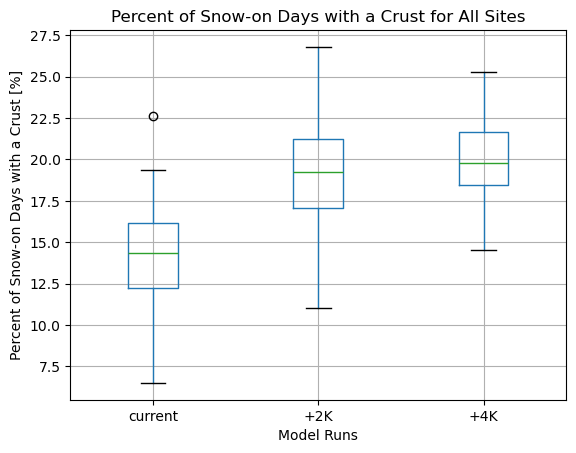

In [16]:
ds_avg['percent_crust_days'] = ds_avg['crusts_binary']/ds_avg['snow_on']*100

# Initialize an empty DataFrame
df = pd.DataFrame()

# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'percent_crust_days' variable for the current 'model_run'
    percent_crust_days = ds_avg['percent_crust_days'].sel(model_run=model_run)
    # Add the 'crust_days' values to the DataFrame
    df[model_run] = percent_crust_days

# Create the box and whisker plots
boxplot = df.boxplot(grid=True, vert=True, return_type='dict')

# Add a horizontal line for the mean value of each column
for line, mean in zip(boxplot['medians'], df.mean()):
    line.set_ydata([mean, mean])


# plt.ylim(0, 100)

# Set the labels
plt.ylabel('Percent of Snow-on Days with a Crust [%]')
plt.xlabel('Model Runs')
plt.title(f'Percent of Snow-on Days with a Crust for All Sites')
# plt.title(f'Percent of Snow-on Days with a Crust for Salmon Meadows')


# Show the plot
plt.show()

## Plot mean DJF temperature

In [17]:
sntls = pd.read_csv('/home/cdalden/summa_setup/analysis/sntl_list_ski_temps.csv', index_col=0)

sntls['elev'] = sntls['elev']/3.281


# sntls['mean_temp_djf'] = (sntls['mean_temp_djf'] - 32) * 5.0/9.0

# Convert airtemp to Kelvin
# sntls['mean_temp_djf'] = (1.03*(sntls['mean_temp_djf']-0.9)) # Currier snotel temp correction

In [18]:
# Normalize the 'percent_crust_days' column for color mapping
norm = matplotlib.colors.Normalize(vmin=sntls['mean_temp_djf'].min(), vmax=sntls['mean_temp_djf'].max())
colormap = matplotlib.cm.get_cmap('RdBu_r')


/tmp/ipykernel_29169/1761259019.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('RdBu_r')


## Compare elevation and mean DJF temps to crust stats

In [19]:
# Calculate the average percent isothermal days for the 'current' and '2K' model runs
ds_avg_current = ds['percent_crust_days'].sel(model_run='current').mean(dim='time')
ds_avg_2K = ds['percent_crust_days'].sel(model_run='+2K').mean(dim='time')
ds_avg_4K = ds['percent_crust_days'].sel(model_run='+4K').mean(dim='time')

# Initialize the 'isothermal_days' column in sntls with NaNs
sntls['percent_crust_days_current'] = np.nan
sntls['percent_crust_days_2K'] = np.nan
sntls['percent_crust_days_4K'] = np.nan

# Assign isothermal days to sntls where ds_avg_current.sel(site) matches the sntls['site_name'] column
for idx, row in sntls.iterrows():
    site_name = row['site_name']
    if site_name in ds_avg_current['site']:
        sntls.at[idx, 'percent_crust_days_current'] = ds_avg_current.sel(site=site_name).item()
        sntls.at[idx, 'percent_crust_days_2K'] = ds_avg_2K.sel(site=site_name).item()
        sntls.at[idx, 'percent_crust_days_4K'] = ds_avg_4K.sel(site=site_name).item()





In [21]:

# Assuming sntls is your DataFrame and model_run is defined
model_run = '+4K'  # Example model run

sntls['percent_crust_days_dif_2K'] = sntls['percent_crust_days_2K'] - sntls['percent_crust_days_current']
sntls['percent_crust_days_dif_4K'] = sntls['percent_crust_days_4K'] - sntls['percent_crust_days_current']


# Filter out rows with NaNs in the relevant columns
filtered_data = sntls.dropna(subset=['mean_temp_djf', 'percent_crust_days_dif_2K', 'percent_crust_days_dif_4K'])

# clip percent_crust_days_dif_2K to have max of 100
filtered_data['percent_crust_days_dif_4K'] = filtered_data['percent_crust_days_dif_4K'].clip(upper=20)

In [23]:
sntls['percent_crust_days_4K'] - sntls['percent_crust_days_current']

# drop inf values
sntls = sntls.replace([np.inf, -np.inf], np.nan)

## Linear Regression for Change in Snow-on Days

In [24]:
# Calculate the average percent isothermal days for the 'current' and '2K' model runs
ds_avg_current = ds['percent_isothermal_days'].sel(model_run='current').mean(dim='time')
ds_avg_2K = ds['percent_isothermal_days'].sel(model_run='+2K').mean(dim='time')
ds_avg_4K = ds['percent_isothermal_days'].sel(model_run='+4K').mean(dim='time')

# Initialize the 'isothermal_days' column in sntls with NaNs
sntls['percent_isothermal_days_current'] = np.nan
sntls['percent_isothermal_days_2K'] = np.nan
sntls['percent_isothermal_days_4K'] = np.nan

# Assign isothermal days to sntls where ds_avg_current.sel(site) matches the sntls['site_name'] column
for idx, row in sntls.iterrows():
    site_name = row['site_name']
    if site_name in ds_avg_current['site']:
        sntls.at[idx, 'percent_isothermal_days_current'] = ds_avg_current.sel(site=site_name).item()
        sntls.at[idx, 'percent_isothermal_days_2K'] = ds_avg_2K.sel(site=site_name).item()
        sntls.at[idx, 'percent_isothermal_days_4K'] = ds_avg_4K.sel(site=site_name).item()


# Two panel regression plot

<>:30: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\D'
<>:66: SyntaxWarning: invalid escape sequence '\d'
<>:75: SyntaxWarning: invalid escape sequence '\d'
<>:101: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\D'
<>:66: SyntaxWarning: invalid escape sequence '\d'
<>:75: SyntaxWarning: invalid escape sequence '\d'
<>:101: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_29169/3174613607.py:30: SyntaxWarning: invalid escape sequence '\d'
  c='powderblue', label=f'$+2\degree$C', edgecolor='k', s=100)
/tmp/ipykernel_29169/3174613607.py:39: SyntaxWarning: invalid escape sequence '\d'
  c='steelblue', label=f'$+4\degree$C', edgecolor='k', 

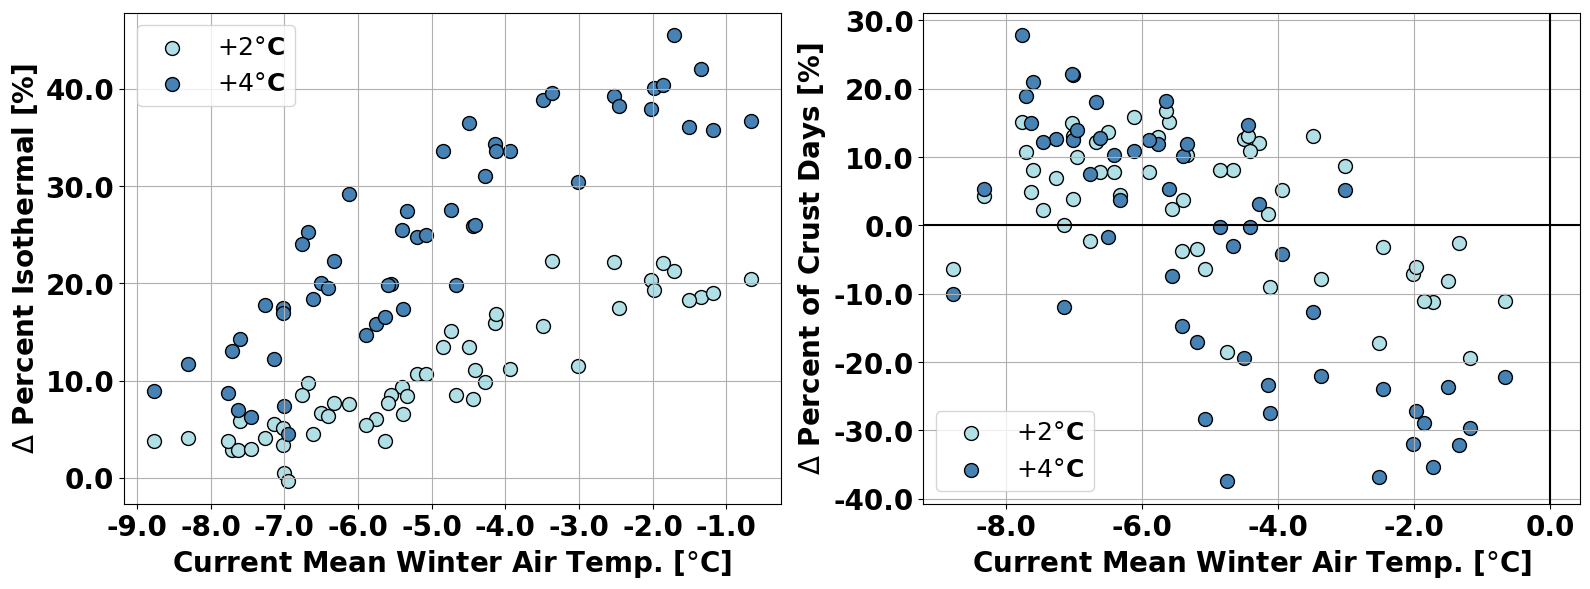

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator
# Set the font properties for the legend
font_properties = FontProperties(weight='bold', size=18)
# Set the font properties for the tick labels
tick_font_properties = FontProperties(weight='bold', size=20)

# Filter out rows with NaNs in the relevant columns
filtered_data = sntls.dropna(subset=['mean_temp_djf', 
                                     'percent_isothermal_days_2K', 'percent_isothermal_days_4K', 
                                     'percent_isothermal_days_current', 'percent_crust_days_dif_4K', 
                                     'elev'])

# Create a 2-paneled plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# plt.subplots_adjust(wspace=40)

# Panel 1: Temperature
# Calculate the coefficients of the linear regression line for +2K
slope, intercept, r_value, p_value, std_err = linregress(filtered_data['mean_temp_djf'], 
                                                         filtered_data['percent_isothermal_days_2K'] - filtered_data['percent_isothermal_days_current'])
r_squared = r_value**2
x = np.linspace(filtered_data['mean_temp_djf'].min(), filtered_data['mean_temp_djf'].max(), 100)
y = slope * x + intercept
# ax1.plot(x, y, color='red')
ax1.scatter(filtered_data['mean_temp_djf'], (filtered_data['percent_isothermal_days_2K'] - filtered_data['percent_isothermal_days_current']), 
            c='powderblue', label=f'$+2\degree$C', edgecolor='k', s=100)

# # Calculate the coefficients of the linear regression line for +4K
# slope, intercept, r_value, p_value, std_err = linregress(filtered_data['mean_temp_djf'], 
#                                                          filtered_data['percent_isothermal_days_4K'] - filtered_data['percent_isothermal_days_current'])
# r_squared = r_value**2
# y = slope * x + intercept
# ax1.plot(x, y, color='red')
ax1.scatter(filtered_data['mean_temp_djf'], (filtered_data['percent_isothermal_days_4K'] - filtered_data['percent_isothermal_days_current']), 
            c='steelblue', label=f'$+4\degree$C', edgecolor='k', s=100)

# Set the tick positions explicitly
ax1.xaxis.set_major_locator(FixedLocator(ax1.get_xticks()))
ax1.yaxis.set_major_locator(FixedLocator(ax1.get_yticks()))

# Change the fontsize and fontweight of x tick labels
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=tick_font_properties)
# Change the fontsize and fontweight of y tick labels
ax1.set_yticklabels(ax1.get_yticks(), fontproperties=tick_font_properties)

# Ensure all tick labels are displayed correctly
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.set_xlabel('Current Mean Winter Air Temp. [$ \degree $C]', fontweight='bold', fontsize=20)
ax1.set_ylabel('$\Delta$ Percent Isothermal [%]', fontweight='bold', fontsize=20)
ax1.grid(True)
# ax1.set_ylim(0, 25)
# Apply the font properties to the legend
ax1.legend(prop=font_properties)



# # Panel 2: Crust Days
# # Plot for +2K
scatter = ax2.scatter(filtered_data['mean_temp_djf'], filtered_data['percent_crust_days_dif_2K'], 
                      c='powderblue', cmap='Blues_r', edgecolor='k', s=100, label=f'$+2\degree$C')
# # Calculate the coefficients of the linear regression line
# slope, intercept, r_value, p_value, std_err = linregress(filtered_data['mean_temp_djf'], filtered_data['percent_crust_days_dif_2K'])
# r_squared = r_value**2
# y = slope * x + intercept
# ax2.plot(x, y, color='red')

# Plot for +4K
scatter = ax2.scatter(filtered_data['mean_temp_djf'], filtered_data['percent_crust_days_dif_4K'], 
                      c='steelblue', cmap='Blues_r', edgecolor='k', s=100, label=f'$+4\degree$C')
# # Calculate the coefficients of the linear regression line
# slope, intercept, r_value, p_value, std_err = linregress(filtered_data['mean_temp_djf'], filtered_data['percent_crust_days_dif_4K'])
# r_squared = r_value**2
# y = slope * x + intercept
# ax2.plot(x, y, color='red')

# Add a horizontal and vertical line at 0
ax2.axhline(0, color='k')
ax2.axvline(0, color='k')


# Set the tick positions explicitly
ax2.xaxis.set_major_locator(FixedLocator(ax2.get_xticks()))
ax2.yaxis.set_major_locator(FixedLocator(ax2.get_yticks()))

# Change the fontsize and fontweight of x tick labels
ax2.set_xticklabels(ax2.get_xticks(), fontproperties=tick_font_properties)
# Change the fontsize and fontweight of y tick labels
ax2.set_yticklabels(ax2.get_yticks(), fontproperties=tick_font_properties)

# Ensure all tick labels are displayed correctly
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)

ax2.set_xlabel(r'Current Mean Winter Air Temp. [$ \degree $C]', fontweight='bold', fontsize=20)
ax2.set_ylabel('$\Delta$ Percent of Crust Days [%]', fontweight='bold', fontsize=20)
ax2.grid(True)
ax2.legend(prop=font_properties)


# # Add labels (a) and (b)
# ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=30, fontweight='bold', va='top', ha='right')
# ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=30, fontweight='bold', va='top', ha='right')

plt.tight_layout()
# plt.show()

plt.savefig('/home/cdalden/summa_setup/analysis/figures/2panel_temp_regression.png', dpi=300, bbox_inches='tight')

In [37]:
ds

<xarray.Dataset> Size: 226kB
Dimensions:                  (time: 25, model_run: 3, site: 53)
Coordinates:
  * time                     (time) datetime64[ns] 200B 2000-01-01 ... 2024-0...
  * model_run                (model_run) <U7 84B 'current' '+2K' '+4K'
  * site                     (site) <U17 4kB 'stevenspass' ... 'grandtarghee'
Data variables:
    mean_crusts              (site, time, model_run) float64 32kB 0.9758 ... ...
    crust_days               (site, time, model_run) float64 32kB 119.1 ... 5...
    snow_on                  (site, time, model_run) float64 32kB 6.216e+03 ....
    crusts_binary            (site, time, model_run) float64 32kB 1.553e+03 ....
    isothermal_days          (site, time, model_run) float64 32kB 1.747e+03 ....
    percent_crust_days       (site, time, model_run) float64 32kB 53.48 ... 4...
    percent_isothermal_days  (site, time, model_run) float64 32kB 28.1 ... 34.51

In [43]:
ds['isothermal_days']

# Calculate the average percent isothermal days for the 'current' and '2K' model runs
ds_avg_current = ds['isothermal_days'].sel(model_run='current').mean(dim='time')/24
ds_avg_2K = ds['isothermal_days'].sel(model_run='+2K').mean(dim='time')/24
ds_avg_4K = ds['isothermal_days'].sel(model_run='+4K').mean(dim='time')/24

# Initialize the 'isothermal_days' column in sntls with NaNs
sntls['isothermal_days_current'] = np.nan
sntls['isothermal_days_2K'] = np.nan
sntls['isothermal_days_4K'] = np.nan

# Assign isothermal days to sntls where ds_avg_current.sel(site) matches the sntls['site_name'] column
for idx, row in sntls.iterrows():
    site_name = row['site_name']
    if site_name in ds_avg_current['site']:
        sntls.at[idx, 'isothermal_days_current'] = ds_avg_current.sel(site=site_name).item()
        sntls.at[idx, 'isothermal_days_2K'] = ds_avg_2K.sel(site=site_name).item()
        sntls.at[idx, 'isothermal_days_4K'] = ds_avg_4K.sel(site=site_name).item()






# Calculate the average percent isothermal days for the 'current' and '2K' model runs
ds_avg_current = ds['crust_days'].sel(model_run='current').mean(dim='time')
ds_avg_2K = ds['crust_days'].sel(model_run='+2K').mean(dim='time')
ds_avg_4K = ds['crust_days'].sel(model_run='+4K').mean(dim='time')

# Initialize the 'isothermal_days' column in sntls with NaNs
sntls['crust_days_current'] = np.nan
sntls['crust_days_2K'] = np.nan
sntls['crust_days_4K'] = np.nan

# Assign isothermal days to sntls where ds_avg_current.sel(site) matches the sntls['site_name'] column
for idx, row in sntls.iterrows():
    site_name = row['site_name']
    if site_name in ds_avg_current['site']:
        sntls.at[idx, 'crust_days_current'] = ds_avg_current.sel(site=site_name).item()
        sntls.at[idx, 'crust_days_2K'] = ds_avg_2K.sel(site=site_name).item()
        sntls.at[idx, 'crust_days_4K'] = ds_avg_4K.sel(site=site_name).item()

<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\D'
<>:58: SyntaxWarning: invalid escape sequence '\d'
<>:62: SyntaxWarning: invalid escape sequence '\d'
<>:88: SyntaxWarning: invalid escape sequence '\D'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\D'
<>:58: SyntaxWarning: invalid escape sequence '\d'
<>:62: SyntaxWarning: invalid escape sequence '\d'
<>:88: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_29169/1743175231.py:25: SyntaxWarning: invalid escape sequence '\d'
  c='powderblue', label=f'$+2\degree$C', edgecolor='k', s=100)
/tmp/ipykernel_29169/1743175231.py:28: SyntaxWarning: invalid escape sequence '\d'
  c='steelblue', label=f'$+4\degree$C', edgecolor='k', s=

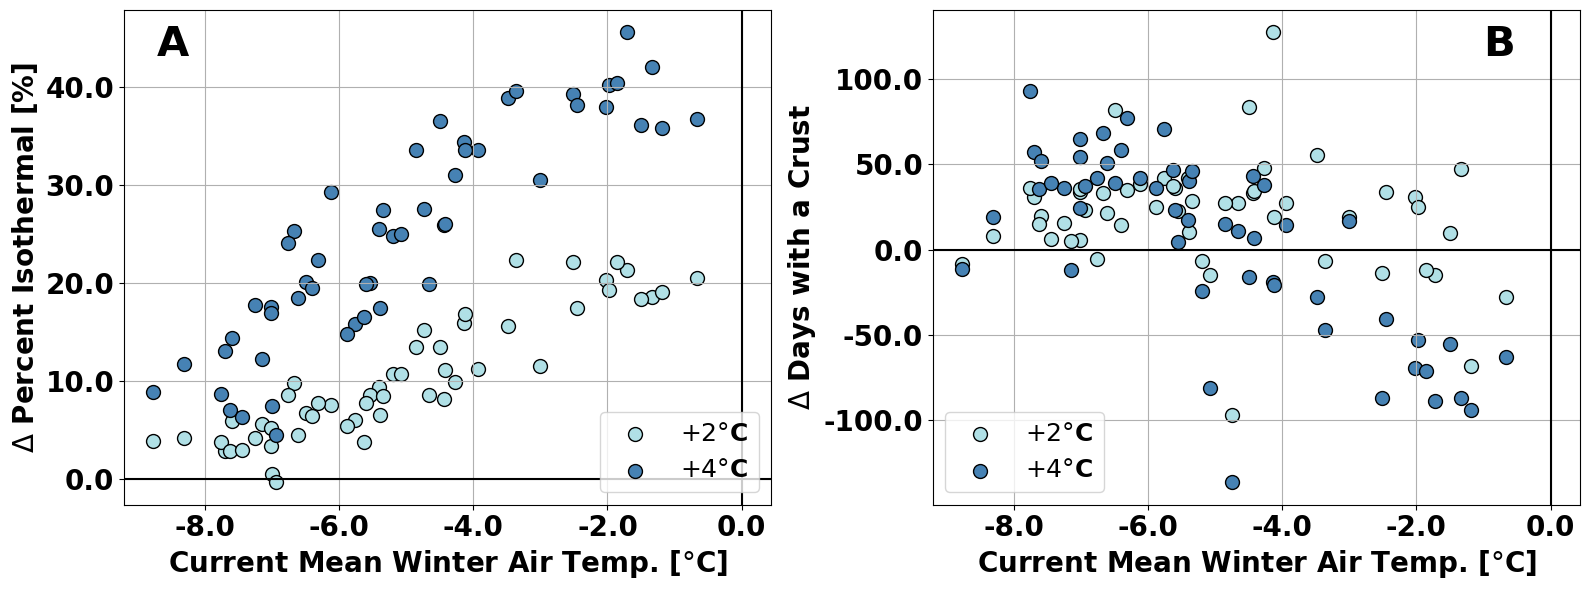

In [54]:
# Set the font properties for the legend
font_properties = FontProperties(weight='bold', size=18)
# Set the font properties for the tick labels
tick_font_properties = FontProperties(weight='bold', size=20)

# Filter out rows with NaNs in the relevant columns
filtered_data = sntls.dropna(subset=['mean_temp_djf', 
                                     'percent_isothermal_days_2K', 'percent_isothermal_days_4K', 
                                     'percent_isothermal_days_current', 'percent_crust_days_dif_4K', 
                                     'elev'])

# Create a 2-paneled plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# plt.subplots_adjust(wspace=40)

# Panel 1: Temperature
# Calculate the coefficients of the linear regression line for +2K
slope, intercept, r_value, p_value, std_err = linregress(filtered_data['mean_temp_djf'], 
                                                         filtered_data['isothermal_days_2K'] - filtered_data['isothermal_days_current'])
r_squared = r_value**2
x = np.linspace(filtered_data['mean_temp_djf'].min(), filtered_data['mean_temp_djf'].max(), 100)
y = slope * x + intercept
# ax1.plot(x, y, color='red')
ax1.scatter(filtered_data['mean_temp_djf'], (filtered_data['percent_isothermal_days_2K'] - filtered_data['percent_isothermal_days_current']), 
            c='powderblue', label=f'$+2\degree$C', edgecolor='k', s=100)

ax1.scatter(filtered_data['mean_temp_djf'], (filtered_data['percent_isothermal_days_4K'] - filtered_data['percent_isothermal_days_current']), 
            c='steelblue', label=f'$+4\degree$C', edgecolor='k', s=100)

ax1.axhline(0, color='k')
ax1.axvline(0, color='k')

# Set the tick positions explicitly
ax1.xaxis.set_major_locator(FixedLocator(ax1.get_xticks()))
ax1.yaxis.set_major_locator(FixedLocator(ax1.get_yticks()))

# Change the fontsize and fontweight of x tick labels
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=tick_font_properties)
# Change the fontsize and fontweight of y tick labels
ax1.set_yticklabels(ax1.get_yticks(), fontproperties=tick_font_properties)

# Ensure all tick labels are displayed correctly
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.set_xlabel('Current Mean Winter Air Temp. [$ \degree $C]', fontweight='bold', fontsize=20)
ax1.set_ylabel('$\Delta$ Percent Isothermal [%]', fontweight='bold', fontsize=20)
ax1.grid(True)
# ax1.set_ylim(0, 25)
# Apply the font properties to the legend
ax1.legend(prop=font_properties, loc='lower right')



# # Panel 2: Crust Days
# # Plot for +2K
scatter = ax2.scatter(filtered_data['mean_temp_djf'], filtered_data['crust_days_2K']-filtered_data['crust_days_current'], 
                      c='powderblue', cmap='Blues_r', edgecolor='k', s=100, label=f'$+2\degree$C')

# Plot for +4K
scatter = ax2.scatter(filtered_data['mean_temp_djf'], filtered_data['crust_days_4K']-filtered_data['crust_days_current'], 
                      c='steelblue', cmap='Blues_r', edgecolor='k', s=100, label=f'$+4\degree$C')
# # Calculate the coefficients of the linear regression line
# slope, intercept, r_value, p_value, std_err = linregress(filtered_data['mean_temp_djf'], filtered_data['percent_crust_days_dif_4K'])
# r_squared = r_value**2
# y = slope * x + intercept
# ax2.plot(x, y, color='red')

# Add a horizontal and vertical line at 0
ax2.axhline(0, color='k')
ax2.axvline(0, color='k')


# Set the tick positions explicitly
ax2.xaxis.set_major_locator(FixedLocator(ax2.get_xticks()))
ax2.yaxis.set_major_locator(FixedLocator(ax2.get_yticks()))

# Change the fontsize and fontweight of x tick labels
ax2.set_xticklabels(ax2.get_xticks(), fontproperties=tick_font_properties)
# Change the fontsize and fontweight of y tick labels
ax2.set_yticklabels(ax2.get_yticks(), fontproperties=tick_font_properties)

# Ensure all tick labels are displayed correctly
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)

ax2.set_xlabel(r'Current Mean Winter Air Temp. [$ \degree $C]', fontweight='bold', fontsize=20)
ax2.set_ylabel('$\Delta$ Days with a Crust', fontweight='bold', fontsize=20)
ax2.grid(True)
ax2.legend(prop=font_properties)


# # Add labels (a) and (b)
ax1.text(0.1, 0.97, 'A', transform=ax1.transAxes, fontsize=30, fontweight='bold', va='top', ha='right')
ax2.text(0.9, 0.97, 'B', transform=ax2.transAxes, fontsize=30, fontweight='bold', va='top', ha='right')

plt.tight_layout()
# plt.show()

plt.savefig('/home/cdalden/summa_setup/analysis/figures/2panel_temp_regression.png', dpi=300, bbox_inches='tight')